In [86]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import psycopg2
warnings.filterwarnings('ignore')

from sqlalchemy import create_engine
from dotenv import load_dotenv

In [87]:
# Load data from sql
def load_data(query: str) -> pd.DataFrame:
    # Load environment variables from .env file
    env_path = os.path.join("..", ".env")
    load_dotenv(dotenv_path=env_path)

    # Retrieve database connection parameters
    DB_USER = os.getenv("DB_USER")
    DB_PASSWORD = os.getenv("DB_PASSWORD")
    DB_HOST = os.getenv("DB_HOST")
    DB_PORT = os.getenv("DB_PORT")
    DB_NAME = os.getenv("DB_NAME")

    # Use psycopg2 directly
    conn = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD
    )
    
    try:
        df = pd.read_sql_query(query, conn)
        return df
    finally:
        conn.close()

In [88]:
# List of queries to select data from all tables

query_1 = "SELECT * FROM inspection.cv_detections;"
query_2 = "SELECT * FROM ml.inspection_training;"
query_3 = "SELECT * FROM ml.inspection_training m LEFT JOIN logistics.shipments s ON m.shipment_id = s.shipment_id;"

# Load dataset Join

In [89]:
df = load_data(query=query_3)
df.head()

,shipment_id,total_detections,avg_confidence,total_damage_area,dent_count,defect_rate,is_high_risk,shipment_id,product_id,supplier_id,shipping_carrier,transportation_mode,route,shipping_cost,total_cost,shipping_time,shipped_at
0,76ca8527-35b6-4b6e-82a5-ac1516853d14,4,0.8425,0.011481,0,0.226086,0,76ca8527-35b6-4b6e-82a5-ac1516853d14,b04965e6-a9bb-591f-8f8a-1adcb2c8dc39,a3257930-e46a-4994-ae1c-28e5a794489e,Carrier B,Road,Route B,3.22,187.49,3,2026-01-24
1,bf046423-d395-4109-8431-e03a6ac08bf5,2,0.8870,0.012859,0,0.232399,1,bf046423-d395-4109-8431-e03a6ac08bf5,7fef88f7-411d-5669-b42d-bf5fc7f9b58b,bccc2020-682a-4478-9518-a1e220548c72,Carrier B,Road,Route B,2.71,186.88,2,2026-01-24
2,160ad73a-faa7-4cd5-a68d-7c351a0c30a1,2,0.8560,0.005352,0,0.224839,0,160ad73a-faa7-4cd5-a68d-7c351a0c30a1,23986425-d3a5-5e13-8bab-299745777a8d,27415fea-7f99-4659-89b0-5ff57dc2ef2b,Carrier B,Road,Route B,2.69,186.70,2,2026-01-24
3,f221fddb-9725-456b-a674-d6c3315328b2,2,0.8660,0.010610,0,0.221834,0,f221fddb-9725-456b-a674-d6c3315328b2,ce1ae2d5-3454-5952-97ff-36ff935bcfe9,bccc2020-682a-4478-9518-a1e220548c72,Carrier B,Road,Route B,2.77,188.46,6,2026-01-24
4,6a5c35a6-8d70-4b53-982e-9ece522a34c2,3,0.9080,0.008472,0,0.227898,0,6a5c35a6-8d70-4b53-982e-9ece522a34c2,8f8173d9-2f8d-5636-a693-24d9f79ba651,bdf8677d-73aa-408a-b2cd-78caba9743e4,Carrier B,Road,Route B,3.31,191.23,2,2026-01-24


# Feature engineering for severity dataset count
- Data ingested by SQL calculation based on dataset

In [90]:
MAX_AREA = df["total_damage_area"].max()
MAX_DET = df["total_detections"].max()
MAX_TIME = df["shipping_time"].max()

# Create cluster
df["norm_damage"] = df["total_damage_area"] / MAX_AREA
df["norm_det"] = df["total_detections"] / MAX_DET
df["norm_time"] = df["shipping_time"] / MAX_TIME

## Severity Score Formula (Production ready for dataset)

In [91]:
"""Estimated with manual calculation from domain knowledge and business understanding. Recheck with model calibration later."""

df["severity_score"] = (
    df["avg_confidence"] * 0.35 +
    df["norm_damage"] * 0.4 +
    df["defect_rate"] * 0.3 +
    df["norm_det"] * 0.2
)

In [92]:
df["severity_score"].describe()

count    926.000000
mean       1.148281
std        0.437746
min        0.323221
25%        0.796137
50%        1.109279
75%        1.511191
max        2.197945
Name: severity_score, dtype: float64

<Axes: >

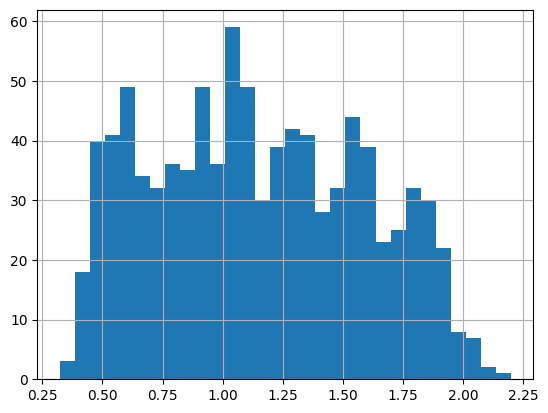

In [93]:
df["severity_score"].hist(bins=30)

In [94]:
# Validate with business label
df[["severity_score", "is_high_risk"]][df["is_high_risk"] == 1].sample(5)

,severity_score,is_high_risk
835,0.836637,1
487,1.271155,1
109,1.774189,1
441,1.163648,1
923,0.560940,1


In [95]:
# Validate with business label
df[["severity_score", "is_high_risk"]][df["is_high_risk"] == 0].sample(5)

,severity_score,is_high_risk
587,0.461805,0
332,0.470994,0
718,0.482466,0
85,0.518918,0
0,0.552123,0


# Split features and labels data

In [96]:

features = df[
    ["avg_confidence",
     "norm_damage",
     "norm_det"]
]

labels = df["is_high_risk"]

# Calibrated and train model

In [97]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

base_model = LogisticRegression(max_iter=3500, 
                                random_state=42, 
                                solver='saga',
                                verbose=1,
                                n_jobs=-1,
                                penalty='elasticnet',
                                l1_ratio=0.5)

calibrated_model = CalibratedClassifierCV(
    base_model,
    method='sigmoid',
    cv=5
)

# Train the model
calibrated_model.fit(features, labels)

# Generate True severity probabilities
df["severity_score"] = calibrated_model.predict_proba(features)[:, 1]

Epoch 1, change: 1.00000000
Epoch 2, change: 0.50841269
Epoch 3, change: 0.16481333
Epoch 4, change: 0.09148419
Epoch 5, change: 0.06716866
Epoch 6, change: 0.05111572
Epoch 7, change: 0.06061959
Epoch 8, change: 0.05245954
Epoch 9, change: 0.04429411
Epoch 10, change: 0.03937181
Epoch 11, change: 0.03235277
Epoch 12, change: 0.02707629
Epoch 13, change: 0.02374488
Epoch 14, change: 0.02023465
Epoch 15, change: 0.01774387
Epoch 16, change: 0.01498077
Epoch 17, change: 0.01301994
Epoch 18, change: 0.01140472
Epoch 19, change: 0.00958720
Epoch 20, change: 0.00831119
Epoch 21, change: 0.00719928
Epoch 22, change: 0.00616219
Epoch 23, change: 0.00534415
Epoch 24, change: 0.00456339
Epoch 25, change: 0.00391826
Epoch 26, change: 0.00336671
Epoch 27, change: 0.00294510
Epoch 28, change: 0.00247901
Epoch 29, change: 0.00214872
Epoch 30, change: 0.00189008
Epoch 31, change: 0.00159943
Epoch 32, change: 0.00135367
Epoch 33, change: 0.00116904
Epoch 34, change: 0.00101558
Epoch 35, change: 0.000

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


In [98]:
# Load model from '../../production_api/model/severity_model.joblib'
import joblib
calibrated_model = joblib.load("../../production_api/model/severity_model.joblib")
calibrated_model.predict_proba(features)[:, 1]

array([0.93657341, 0.92988102, 0.92813105, 0.9293959 , 0.93282776,
       0.93098289, 0.92791737, 0.93706271, 0.93169339, 0.92879684,
       0.9289143 , 0.93433528, 0.94293495, 0.92920522, 0.9363168 ,
       0.93393214, 0.93921588, 0.9230415 , 0.94053949, 0.9289028 ,
       0.92876266, 0.9238732 , 0.93093005, 0.92778348, 0.92894958,
       0.93132908, 0.9322082 , 0.93708185, 0.93426346, 0.92915794,
       0.92851478, 0.93696658, 0.93503751, 0.92962444, 0.92322945,
       0.93603299, 0.93729857, 0.93150811, 0.93391204, 0.93807766,
       0.92977244, 0.93001414, 0.92179988, 0.92870745, 0.92949058,
       0.92967725, 0.92274229, 0.93183447, 0.93051812, 0.93373486,
       0.929347  , 0.93561844, 0.9377306 , 0.94138278, 0.92171739,
       0.93040681, 0.93790377, 0.92194901, 0.92380753, 0.92488412,
       0.93047249, 0.93375838, 0.92796008, 0.9279108 , 0.92938517,
       0.93493825, 0.93238961, 0.92795797, 0.93004709, 0.93843797,
       0.9293879 , 0.93456835, 0.92996804, 0.9412499 , 0.93348

# Clip Probability Range (Industry Trick)

In [99]:
df["severity_score"] = df["severity_score"].clip(0.05, 0.95) # Clip Probability Range (Industry Trick)

In [100]:
pd.DataFrame(df["severity_score"]).head(7)

,severity_score
0,0.936573
1,0.929881
2,0.928131
3,0.929396
4,0.932828
5,0.930983
6,0.927917


# Create THRESHOLD and Describe statistically relevant dataset

In [101]:
THRESHOLDS = {
    "low": df["severity_score"].quantile(0.60),
    "medium": df["severity_score"].quantile(0.80),
    "high": df["severity_score"].quantile(0.95),
}

print(f"Data after calibration:\n{df['severity_score'].describe()}\n")
print(f"Thresholds after calibration:\n{THRESHOLDS}")

Data after calibration:
count    926.000000
mean       0.931534
std        0.004491
min        0.921365
25%        0.929043
50%        0.930976
75%        0.934516
max        0.945341
Name: severity_score, dtype: float64

Thresholds after calibration:
{'low': 0.9320937933184918, 'medium': 0.9354655830250385, 'high': 0.939098586258811}


Low         555
Medium      185
High        139
Critical     47
Name: risk_level, dtype: int64


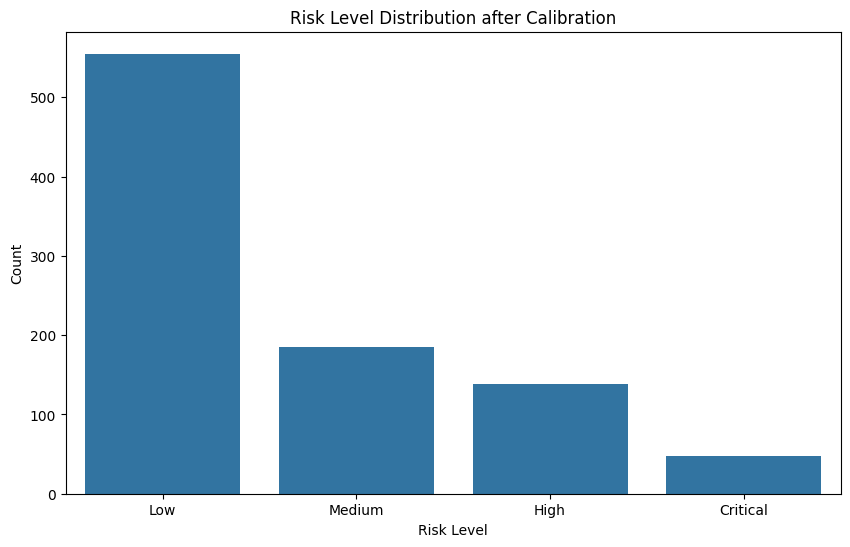

In [102]:
# Create function to map category based on threshold values are dynamic
def categorize_risk(score:float, thresholds:dict=THRESHOLDS) -> str:
    if score >= thresholds["high"]:
        return "Critical"
    elif score >= thresholds["medium"]:
        return "High"
    elif score >= thresholds["low"]:
        return "Medium"
    else:
        return "Low"
    
# apply into dataframe
df["risk_level"] = df["severity_score"].apply(categorize_risk, thresholds=THRESHOLDS)

# validate final result
print(df["risk_level"].value_counts())

# visualize final result
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="risk_level", order=["Low", "Medium", "High", "Critical"])
plt.title("Risk Level Distribution after Calibration")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()

# Visual debug for severity score

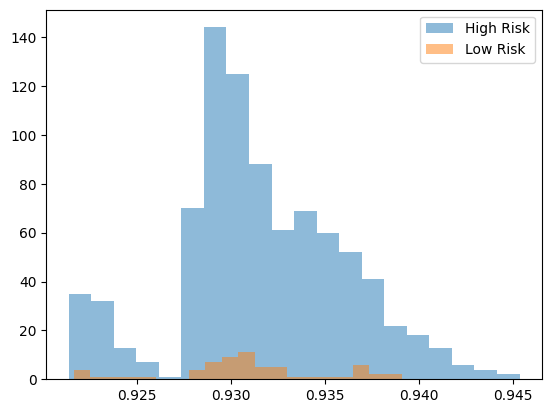

In [103]:
import matplotlib.pyplot as plt

plt.hist(
    df[df.is_high_risk == 1]["severity_score"],
    bins=20, # bins is the number of bars in the histogram
    alpha=0.5,
    label='High Risk'
)

plt.hist(
    df[df.is_high_risk == 0]["severity_score"],
    bins=20,
    alpha=0.5,
    label='Low Risk'
)

plt.legend()
plt.show()

In [104]:
# Validate with business label
df[["severity_score", "is_high_risk"]][df["is_high_risk"] == 1].sample(5)

,severity_score,is_high_risk
758,0.934025,1
510,0.928939,1
471,0.928258,1
145,0.935947,1
465,0.936653,1


In [105]:
# Validate with business label
df[["severity_score", "is_high_risk"]][df["is_high_risk"] == 0].sample(5)

,severity_score,is_high_risk
57,0.921949,0
122,0.936683,0
118,0.933123,0
564,0.929841,0
721,0.922364,0


In [106]:
raw_scores = calibrated_model.predict_proba(features)[:, 1]
raw_scores

array([0.93657341, 0.92988102, 0.92813105, 0.9293959 , 0.93282776,
       0.93098289, 0.92791737, 0.93706271, 0.93169339, 0.92879684,
       0.9289143 , 0.93433528, 0.94293495, 0.92920522, 0.9363168 ,
       0.93393214, 0.93921588, 0.9230415 , 0.94053949, 0.9289028 ,
       0.92876266, 0.9238732 , 0.93093005, 0.92778348, 0.92894958,
       0.93132908, 0.9322082 , 0.93708185, 0.93426346, 0.92915794,
       0.92851478, 0.93696658, 0.93503751, 0.92962444, 0.92322945,
       0.93603299, 0.93729857, 0.93150811, 0.93391204, 0.93807766,
       0.92977244, 0.93001414, 0.92179988, 0.92870745, 0.92949058,
       0.92967725, 0.92274229, 0.93183447, 0.93051812, 0.93373486,
       0.929347  , 0.93561844, 0.9377306 , 0.94138278, 0.92171739,
       0.93040681, 0.93790377, 0.92194901, 0.92380753, 0.92488412,
       0.93047249, 0.93375838, 0.92796008, 0.9279108 , 0.92938517,
       0.93493825, 0.93238961, 0.92795797, 0.93004709, 0.93843797,
       0.9293879 , 0.93456835, 0.92996804, 0.9412499 , 0.93348

# MinMax Scaling data

In [107]:
# Before scaling about describe the distribution of severity scores
df["severity_score"].describe()

count    926.000000
mean       0.931534
std        0.004491
min        0.921365
25%        0.929043
50%        0.930976
75%        0.934516
max        0.945341
Name: severity_score, dtype: float64

In [108]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df["severity_score"] = scaler.fit_transform(
    raw_scores.reshape(-1, 1)
)

# After MinMax Scaling describe the distribution of severity scores
df["severity_score"].describe()

count    926.000000
mean       0.424120
std        0.187305
min        0.000000
25%        0.320223
50%        0.400836
75%        0.548502
max        1.000000
Name: severity_score, dtype: float64

In [109]:
# Create another THRESHOLD after MinMax Scaling
DEBUG_THRESHOLDS = {
    "low": df["severity_score"].quantile(0.60),
    "medium": df["severity_score"].quantile(0.80),
    "high": df["severity_score"].quantile(0.95),
}

print(f"Before Scaling Thresholds:\n{THRESHOLDS}\n")
print(f"After Scaling Thresholds:\n{DEBUG_THRESHOLDS}\n")

Before Scaling Thresholds:
{'low': 0.9320937933184918, 'medium': 0.9354655830250385, 'high': 0.939098586258811}

After Scaling Thresholds:
{'low': 0.4474771155798436, 'medium': 0.5881102616366434, 'high': 0.7396382983371446}



Original THRESHOLDS vs DEBUG_THRESHOLDS after MinMax Scaling
low: 0.9321 vs 0.4475
medium: 0.9355 vs 0.5881
high: 0.9391 vs 0.7396


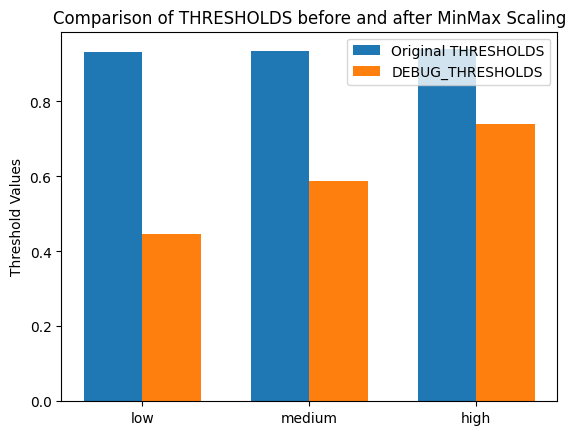

In [110]:
# Comparison THRESHOLDS vs DEBUG_THRESHOLDS
print("Original THRESHOLDS vs DEBUG_THRESHOLDS after MinMax Scaling")
for key in THRESHOLDS.keys():
    print(f"{key}: {THRESHOLDS[key]:.4f} vs {DEBUG_THRESHOLDS[key]:.4f}")

# Visualize THRESHOLDS comparison
labels = list(THRESHOLDS.keys())
original_values = [THRESHOLDS[key] for key in labels]
debug_values = [DEBUG_THRESHOLDS[key] for key in labels]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, original_values, width=width, label='Original THRESHOLDS')
bars2 = ax.bar(x + width/2, debug_values, width=width, label='DEBUG_THRESHOLDS')
# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Threshold Values')
ax.set_title('Comparison of THRESHOLDS before and after MinMax Scaling')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [111]:
# Sanity check values on bars into percentage
print("Percentage distribution after MinMax Scaling:")
pd.cut(
    df["severity_score"],
    bins=[0, DEBUG_THRESHOLDS["low"], DEBUG_THRESHOLDS["medium"], DEBUG_THRESHOLDS["high"], 1],
    labels=["Low", "Medium", "High", "Critical"]
).value_counts(normalize=True).mul(100).round(2)

Percentage distribution after MinMax Scaling:


Low         60.00
Medium      20.00
High        14.92
Critical     5.08
Name: severity_score, dtype: float64

In [115]:
df['is_high_risk'].value_counts()

1    863
0     63
Name: is_high_risk, dtype: int64